In [ ]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
from torch.nn import Linear, Sequential, ReLU, LeakyReLU
from torch.optim import Adam

In [83]:
# run only if new data is desired
ode_dim = 4
n_data = 5
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,1280)

dataset = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=128,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    p = param_test[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset.append(to_pyg_data(x_test[i],param_tensor,ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [84]:
from torch.nn import Linear, Sequential, LeakyReLU
from torch_geometric.nn import GATConv

class GCNEncoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels=10):
        super(GCNEncoder, self).__init__()
        self.conv1 = GATConv(in_channels,4*out_channels)
        self.conv2 = GATConv(4*out_channels,2*out_channels)
        self.conv3 = GATConv(2*out_channels, 2*out_channels)
        self.conv4 = GATConv(2*out_channels, out_channels)
        self.conv5 = GATConv(out_channels, out_channels)

        self.edge_mlp = Sequential(
            Linear(2 * in_channels + 1, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, hidden_channels),
            LeakyReLU(),
            Linear(hidden_channels, 1)
        )

    def forward(self, data, edge_index):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        edge_attr = edge_attr + self.update_attributes(x,edge_index,edge_attr, self.edge_mlp)

        x = self.conv1(x, edge_index=edge_index, edge_attr=edge_attr)
        x = torch.nn.functional.leaky_relu(x)
        x = self.conv2(x,edge_index=edge_index, edge_attr=edge_attr)
        x = torch.nn.functional.leaky_relu(x)
        x = self.conv3(x,edge_index=edge_index, edge_attr=edge_attr)
        x = torch.nn.functional.leaky_relu(x)
        x = self.conv4(x,edge_index=edge_index, edge_attr=edge_attr)
        x = torch.nn.functional.leaky_relu(x)
        return self.conv5(x, edge_index=edge_index, edge_attr=edge_attr)
    
    def update_attributes(self, x, edge_index, edge_attr, mlp):

        row, col = edge_index
        src, tgt = x[row], x[col]

        # Concatenate node features with edge attributes
        edge_features = torch.cat([src, tgt, edge_attr], dim=-1)

        # Update edge attributes using an MLP
        edge_attr = mlp(edge_features)

        return edge_attr

In [87]:
model = GAE(GCNEncoder(2*n_data,10))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to('cpu')

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

criterion = torch.nn.MSELoss()

train_loss = []

for epoch in range(100):
    model.train()

    tr_loss = 0
    full_loss = 0
    for data in loader:
        optimizer.zero_grad()

        z = model.encode(data, data.edge_index)
        recon = model.decode(z, data.edge_index)

        loss = criterion(recon,data.edge_attr.flatten())

        train_loss.append(loss)

        full_loss += loss

        loss.backward()
        optimizer.step()
        
        tr_loss += loss
    train_loss.append(full_loss)
    print(full_loss.item())

43.00249099731445
43.01429748535156
42.87220764160156
42.789573669433594
42.780609130859375
42.80693054199219
42.73688888549805
42.72981262207031
42.74364471435547
42.729427337646484
42.70298767089844
42.728599548339844
42.747642517089844
42.694984436035156
42.72602462768555
42.68968963623047
42.67448806762695
42.68158721923828
42.6883544921875
42.76411437988281
42.70384979248047
42.68947982788086
42.70429611206055
42.72849655151367
42.659385681152344
42.66979217529297
42.683372497558594
42.65560531616211
42.64891815185547
42.66754150390625
42.68598175048828
42.66453552246094
42.64799880981445
42.63758850097656
42.680328369140625
42.65128707885742
42.649986267089844
42.68952941894531
42.677650451660156
42.67448425292969
42.67405700683594
42.662071228027344
42.65693664550781
42.63142013549805
42.60297775268555
42.660675048828125
42.625492095947266
42.61126708984375


KeyboardInterrupt: 

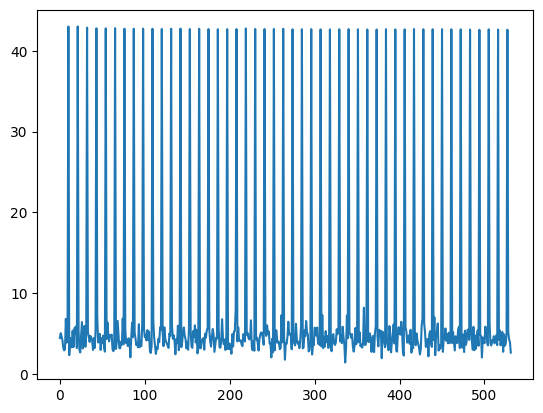

In [88]:
import matplotlib.pyplot as plt

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.show()